In [100]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import hvplot.pandas
import scipy.stats as st

# Import the API key
from config import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [101]:
# Geographical Data Source: https://www.aihw.gov.au/about-our-data/aihw-data-by-geography
# LGA Data source: https://www.aihw.gov.au/reports/life-expectancy-death/mort-books/contents/mort-books
# Read excel File
mort_xl_path = "Data\AIHW_LGA_MORT_2016-2020.xlsx"
mort_raw_df = pd.read_excel(mort_xl_path, sheet_name="LGA")

# Clean data: rename columns
mort_raw_df = mort_raw_df.rename(columns={"Persons": "LGA " + mort_raw_df.iloc[1,0],
                                    "Unnamed: 1": mort_raw_df.iloc[1,1],
                                    "Unnamed: 2": mort_raw_df.iloc[1,2],
                                    "Unnamed: 3": mort_raw_df.iloc[1,3],
                                    "Unnamed: 4": mort_raw_df.iloc[1,4],
                                    "Unnamed: 5": mort_raw_df.iloc[1,5],
                                    "Unnamed: 6": mort_raw_df.iloc[1,6],
                                    "Unnamed: 7": mort_raw_df.iloc[1,7],
                                    "Unnamed: 8": mort_raw_df.iloc[1,8],
                                    "Unnamed: 9": mort_raw_df.iloc[1,9],
                                    "Unnamed: 10": mort_raw_df.iloc[1,10],
                                    "Unnamed: 11": mort_raw_df.iloc[1,11],
                                    })

# https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe
# Clean data: remove unnecessary rows
mort_raw_df.drop([0, 1], axis=0, inplace=True)

# Clean data: reset the index to 0
mort_raw_df.reset_index(inplace=True)
mort_clean_df = mort_raw_df.drop(["index"], axis=1)

# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/
# Clean data: edit "Name" field to keep LGA name only
mort_clean_df["Name"] = mort_clean_df["Name"].str.split(" ", n = 1, expand = True)[0]

# Prepare data: extract data for 2020 and reset index
mort_clean_2020_df = mort_clean_df[mort_clean_df["Year"] == 2020].reset_index()
mort_clean_2020_df = mort_clean_2020_df.drop(["index"], axis=1)

# View 2020 data
mort_clean_2020_df.head(10)

,LGA Reference,Name,Council Seat,Year,Total deaths,Population,"Crude rate (per 100,000)","Age-standardised rate (per 100,000)",Median age at death (years),Premature deaths,Premature deaths (% of total deaths),"Premature deaths age-standardised rate (per 100,000)"
0,LGA20110,Alpine,Bright,2020,100.82235,12967.899,777.47639,436.90781,84.03486,20.303629,20.138023,107.6718
1,LGA20260,Ararat,Ararat,2020,104.62816,11988.374,872.74682,479.59467,81.65744,35.646489,34.069691,214.17096
2,LGA20570,Ballarat,Ballarat,2020,840.96821,111436.23,754.66322,559.05232,80.98837,295.69342,35.16107,237.34514
3,LGA20660,Banyule,Ivanhoe,2020,882,132009,668.13626,444.07029,84.92,233,26.417234,156.67519
4,LGA20740,Bass,Wonthaggi,2020,377.90186,37431.241,1009.5895,512.18662,82.1806,113.63982,30.071253,196.60128
5,LGA20830,Baw,Warragul,2020,432.83824,54811.739,789.68163,538.8695,81.88953,137.48832,31.764366,188.56067
6,LGA20910,Bayside,Sandringham,2020,815,107541,757.85049,419.74013,87.46774,174,21.349693,135.51501
7,LGA21010,Benalla,Benalla,2020,169.65234,14155.183,1198.5175,585.29129,83.43859,47.794566,28.172064,221.25978
8,LGA21110,Boroondara,Camberwell,2020,996,182996,544.27419,357.24911,87.43478,207,20.783133,103.55824
9,LGA21180,Brimbank,Sunshine,2020,1199,208183,575.9356,501.51213,81.22973,436,36.363636,192.58226


In [102]:
# Declare columns: for longitude and latitude data
mort_clean_2020_df["Latitude"] = ""
mort_clean_2020_df["Longitude"] = ""

# Declare parameters: for the API request
params = {
    "apiKey": geoapify_key
}

# Build URL using the geocode endpoint
base_url = "https://api.geoapify.com/v1/geocode/search"

# Iterate through the mort_clean_2020_df DataFrame
for index, row in mort_clean_2020_df.iterrows():
    target_LGA = mort_clean_2020_df.loc[index, "Council Seat"]
    params["text"] = target_LGA + ", Victoria, Australia"

    long_lat_data_json = requests.get(base_url, params=params).json()

    try:
        mort_clean_2020_df.loc[index, "Longitude"] = long_lat_data_json["features"][0]["properties"]["lon"]
        mort_clean_2020_df.loc[index, "Latitude"] = long_lat_data_json["features"][0]["properties"]["lat"]
    except (KeyError, IndexError):
    # If no coordinates are found, set the geo-coordinates to NaN
        mort_clean_2020_df.loc[index, "Longitude"] = np.nan
        mort_clean_2020_df.loc[index, "Latitude"] = np.nan

In [103]:
# Declare columns: for number of hospitals
mort_clean_2020_df["Hospitals Count"] = ""

# Declare parameters: for the API request for hospitals
categories = "healthcare.hospital"
radius = 25000

# Set the parameters for the type of search
limit = 200

# set up a parameters dictionary
params = {
    "categories":categories,
    "limit": limit,
    "apiKey":geoapify_key    
}

# Set base URL
base_url = "https://api.geoapify.com/v2/places"


# Iterate through the num_uniq_serv_per_hospitals_VIC_2017_df DataFrame
for index, row in mort_clean_2020_df.iterrows():
    latitude_LGA = mort_clean_2020_df.loc[index, "Latitude"]
    longitude_LGA = mort_clean_2020_df.loc[index, "Longitude"]
    params["filter"] = f"circle:{longitude_LGA},{latitude_LGA},{radius}"
    params["bias"] = f"proximity:{longitude_LGA},{latitude_LGA}"

    num_hospitals_data_json = requests.get(base_url, params=params).json()

    try:
        mort_clean_2020_df.loc[index, "Hospitals Count"] = len(num_hospitals_data_json["features"])
    except (KeyError, IndexError):
    # If no hospital is found, set the count to NaN
        mort_clean_2020_df.loc[index, "Hospitals Count"] = np.nan

print(mort_clean_2020_df.to_string())

   LGA Reference          Name     Council Seat  Year Total deaths Population Crude rate (per 100,000) Age-standardised rate (per 100,000) Median age at death (years) Premature deaths Premature deaths (% of total deaths) Premature deaths age-standardised rate (per 100,000)   Latitude   Longitude Hospitals Count
0       LGA20110        Alpine           Bright  2020    100.82235  12967.899                777.47639                           436.90781                    84.03486        20.303629                            20.138023                                             107.6718 -36.728533  146.960772               3
1       LGA20260        Ararat           Ararat  2020    104.62816  11988.374                872.74682                           479.59467                    81.65744        35.646489                            34.069691                                            214.17096 -37.284344  142.930621               1
2       LGA20570      Ballarat         Ballarat  2020    840.

The correlation between nearby hospitals and age standardised adult death rate (per 100,00) is -0.62


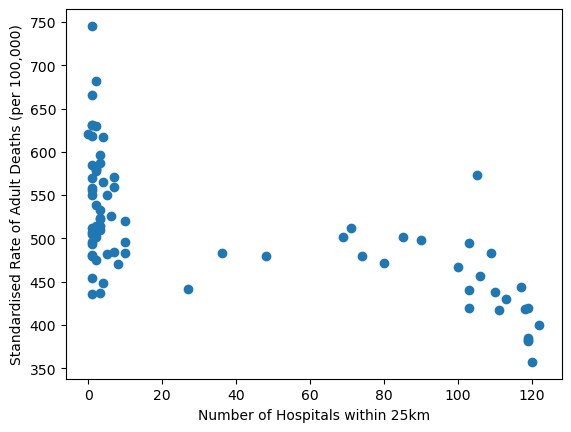

In [104]:
# Generate a scatter plot of Hospitals Count vs. Premature deaths (% of total deaths)
y_axis = mort_clean_2020_df["Age-standardised rate (per 100,000)"]
x_axis = mort_clean_2020_df["Hospitals Count"]

# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
corr_coef = round(st.pearsonr(x_axis,y_axis)[0],2)
print(f"The correlation between nearby hospitals and age standardised adult death rate (per 100,00) is {corr_coef}")

plt.scatter(x_axis, y_axis, marker="o")
# plt.axhline(y=435, color= 'green', linewidth=1)
# plt.axvline(x=95, color= 'green', linewidth=1)
plt.xlabel("Number of Hospitals within 25km")
plt.ylabel("Standardised Rate of Adult Deaths (per 100,000)")
plt.show()

In [105]:
# Configure the map plot_3
map_plot_1 = mort_clean_2020_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color = "Council Seat"
)

# Display the map plot
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Council Seat)

In [106]:
# Prepare data: extract data for 2016 and reset index
mort_clean_2016_df = mort_clean_df[mort_clean_df["Year"] == 2016].reset_index()
mort_clean_2016_df = mort_clean_2016_df.drop(["index"], axis=1)

# View 2020 data
mort_clean_2016_df.head(10)

,LGA Reference,Name,Council Seat,Year,Total deaths,Population,"Crude rate (per 100,000)","Age-standardised rate (per 100,000)",Median age at death (years),Premature deaths,Premature deaths (% of total deaths),"Premature deaths age-standardised rate (per 100,000)"
0,LGA20110,Alpine,Bright,2016,124.58405,12586.316,989.83733,577.58725,81.34028,35.877926,28.798169,197.75177
1,LGA20260,Ararat,Ararat,2016,120.83495,11746.324,1028.7044,600.02239,84.00806,29.023839,24.019408,198.92586
2,LGA20570,Ballarat,Ballarat,2016,809.92263,103514.56,782.42389,585.72869,82.16119,253.39969,31.286901,225.42131
3,LGA20660,Banyule,Ivanhoe,2016,799,127447,626.92727,436.39145,84.53704,210,26.282854,149.21752
4,LGA20740,Bass,Wonthaggi,2016,325.72838,33465.373,973.3296,515.42624,81.24909,102.49991,31.467907,220.47323
5,LGA20830,Baw,Warragul,2016,374.52299,49289.262,759.84701,530.12068,82.69067,119.79938,31.987189,192.73963
6,LGA20910,Bayside,Sandringham,2016,799,102912,776.39148,430.75811,87.21667,170,21.276596,143.57676
7,LGA21010,Benalla,Benalla,2016,158.69975,13985.747,1134.7249,573.28239,84.27765,40.841974,25.735374,213.37428
8,LGA21110,Boroondara,Camberwell,2016,1145,177276,645.88551,429.60169,87.27679,229,20,123.637
9,LGA21180,Brimbank,Sunshine,2016,1118,204194,547.51854,543.63383,80.09375,427,38.193202,207.72541


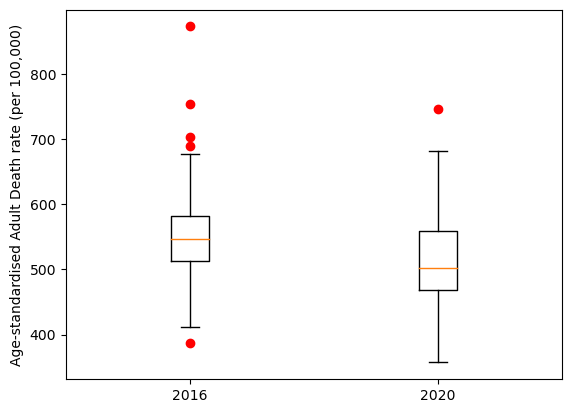

In [107]:
#Create DataFrame for plotting
mort_2016_2020_df = pd.DataFrame({"Name": mort_clean_2016_df["Council Seat"],
                                  "2016": mort_clean_2016_df["Age-standardised rate (per 100,000)"],
                                  "2020": mort_clean_2020_df["Age-standardised rate (per 100,000)"]
                                  })


fig1, ax1 = plt.subplots()
ax1.set_ylabel('Age-standardised Adult Death rate (per 100,000)')
ax1.set_xticklabels(["2016", "2020"])
ax1.boxplot([mort_2016_2020_df["2016"], mort_2016_2020_df["2020"]], 0, 'ro')
plt.show()  


<Axes: xlabel='Victorian LGAs', ylabel='Change in Death Rate'>

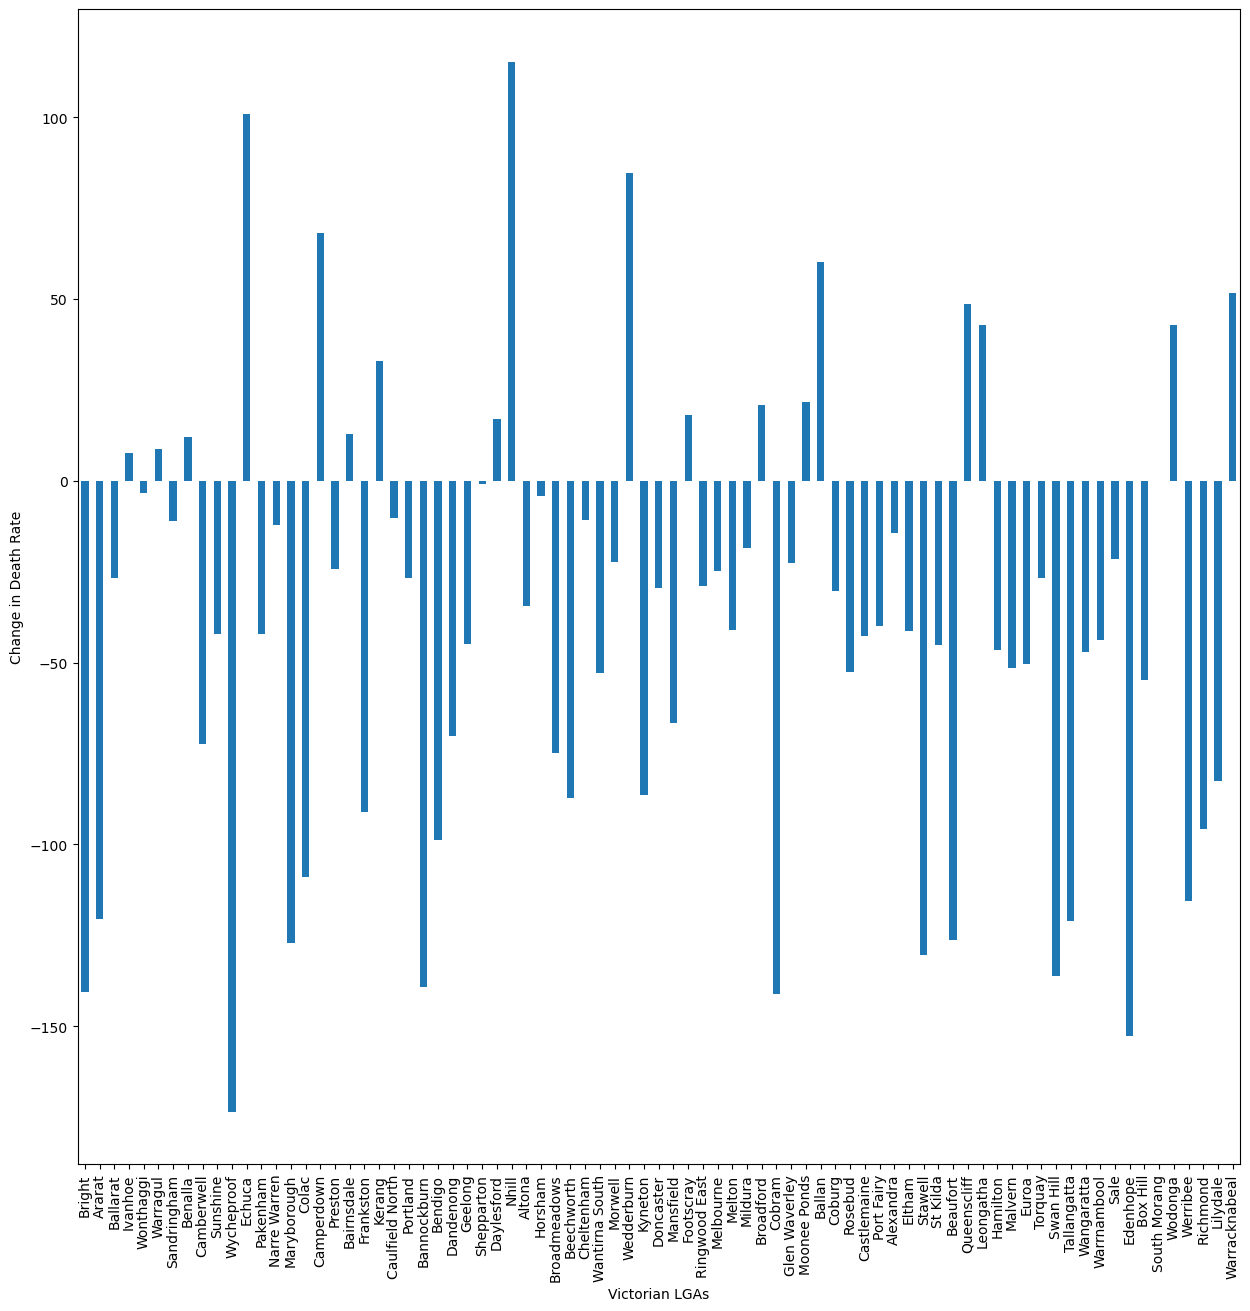

In [108]:
mort_2016_2020_df["Inc/Dec in Death Rate"] = mort_2016_2020_df["2020"] - mort_2016_2020_df["2016"]

mort_2016_2020_df.plot(x="Name", y=["Inc/Dec in Death Rate"], xlabel="Victorian LGAs", ylabel="Change in Death Rate", legend=False,kind="bar", stacked=False, figsize=(15,15))

In [109]:
st.ttest_rel(mort_2016_2020_df["2016"], mort_2016_2020_df["2020"])

TtestResult(statistic=5.423823749465126, pvalue=6.339494789703114e-07, df=78)

As the p-values is <<<0.05, we reject the null hypothesis of the paired/dependent t-test and conclude that there is a difference in age-standardised adult death rate (per 100,000) means.
This is supported by the box-whisker plot and bar plot.

NOTE: the null hypothesis is that the true difference between the group means is zero